# <center> Demand Response Intervention </center> 

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
LABELS = ['so2_kg', 'nox_kg', 'pm25_kg', 'co2_kg', 'so2_dam_ap2', 'nox_dam_ap2',
       'pm25_dam_ap2', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas',
       'co2_dam', 'dam_ap2', 'dam_eas']
LABELS.sort()
SE_LABELS = ['{}-se'.format(x) for x in LABELS]
dam_cols_ap2 = ['co2_dam', 'so2_dam_ap2', 'nox_dam_ap2', 'pm25_dam_ap2']
dam_cols_eas = ['co2_dam', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas']

In [3]:
GROUPING_NAMES = ['SeasonalTOD', 'MonthTOD', 'TOD', 'YearOnly', 'Month']
GROUPING_COLS = [['year', 'season', 'hour'], ['year', 'month', 'hour'], 
        ['year', 'hour'], ['year'], ['year', 'month']]
GROUPING_NAMES_COLS = dict(zip(GROUPING_NAMES, GROUPING_COLS))

## Read in data 

In [4]:
def get_factor_df(kind='MEF', time='Month', region='PJM', fuel_type='FossilOnly'):
    kind_folder = 'mefs' if kind=='MEF' else 'aefs'
    
    # Read in file
    if fuel_type == 'FossilOnly':
        region_breakdown = 'isorto' if region == 'PJM' else 'nerc'
        df = pd.read_csv(os.path.join(os.pardir, os.pardir, 'factor_estimates', 'calculated_factors', 
                                      kind_folder, time, 
                                      '{}_{}.csv'.format(region_breakdown, kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        df = df[df[region_breakdown] == region].drop(region_breakdown, axis=1)
    else:
        if region != 'PJM':
            raise NotImplementedError('fossil-plus factors are only available for PJM')
        df = pd.read_csv(os.path.join(os.pardir, os.pardir, 'factor_estimates', 'calculated_factors', 
                                      kind_folder, time, 
                                      'pjm_fplus_{}.csv'.format(kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        
    # Filter MEF columns
    if kind == 'MEF':
        df = df.drop([x for x in df.columns if '-r' in x or '-int' in x], axis=1)
        df.columns = [x.replace('-est', '') for x in df.columns]
        
    # Ensure columns have numeric type
    df = df.apply(pd.to_numeric, axis=1)
    
    return df

In [5]:
all_dfs = {}
for kind in ['MEF', 'AEF']:
    for region in ['PJM', 'RFC']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            for time in ['YearOnly', 'Month']:
                if region == 'RFC' and fuel_type == 'FossilPlus': 
                    continue
#                 print(kind, region, fuel_type, time)
                df = get_factor_df(kind=kind, time=time, region=region, fuel_type=fuel_type)
                all_dfs[(kind, region, fuel_type, time)] = df

## Get DR reductions

In [6]:
import calendar
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
intervention_df = pd.DataFrame(pd.read_csv(os.path.join(os.pardir, 'demand_response', 'monthly_dr.csv'), index_col=0).stack())
intervention_df.index.names = ['year', 'month']
intervention_df.columns = ['MWh']

months2017 = pd.date_range(start='2017-01-01', end='2017-12-31', freq='MS')
intervention_df = intervention_df[intervention_df.index.get_level_values('year') == 2017]
intervention_df.index = months2017

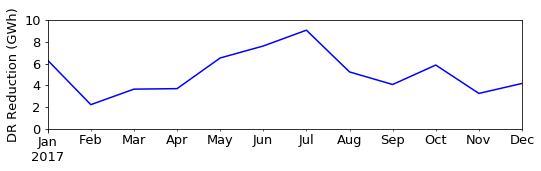

In [8]:
fontsize=13

fig, ax = plt.subplots(figsize=(8.5, 2))
# # df = dr_reductions[dr_reductions.index.get_level_values('year') == 2017]/1e3
# rev_month_dict = dict((k,v) for k,v in enumerate(calendar.month_abbr))
# xticks = pd.date_range(start='2017-01-01', end='2017-12-31', freq='M')
df = intervention_df/1e3

# df = df.set_index(df.index.get_level_values('month').map(lambda x: rev_month_dict[x]))
# df.index = df.index.map(lambda x: pd.datetime(x[0], x[1], 1))
df.plot(color='blue', ax=ax, legend=False, fontsize=fontsize);

ax.set_ylim(0,10)
ax.set_ylabel('DR Reduction (GWh)');
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(13)
# if not os.path.exists(os.path.join('figures', 'dr')):
#     os.makedirs(os.path.join('figures', 'dr'))
# fig.savefig(os.path.join('figures', 'dr', 'dr_profile.pdf'), bbox_inches='tight')

## Get intervention effects

In [9]:
def get_month_factors(df, time, months, prev_year=False):
    year_series = months.map(lambda x: x.year-1) if prev_year else months.map(lambda x: x.year)
    month_series = months.map(lambda x: x.month)
#     hour_series = hours2017.map(lambda x: x.hour)
    if time == 'YearOnly':
        df2 = df.loc[year_series]
    elif time == 'Month':
        df2 = df.loc[list(zip(year_series, month_series))]
    df2 = df2.set_index(months)
    return df2

In [10]:
# Get factor for each point in time series
months2017_factors = {}
for key in all_dfs.keys():
#     print(key)
    df = all_dfs[key]
    
    # 2017
    df2 = get_month_factors(df, key[-1], months2017)
    months2017_factors[key + (2017,)] = df2
    
    # 2016 for PJM fossil-only
    if key[1] == 'PJM' and key[2] == 'FossilPlus':
        df3 = get_month_factors(df, key[-1], months2017, True)
        months2017_factors[key + (2016,)] = df3

In [11]:
# Calculate effects
intervention_effects = {}
for key in months2017_factors.keys():
    reds = months2017_factors[key].multiply(intervention_df['MWh'], axis='index')
    effects = reds[LABELS].sum()  # total effect
    
    # For MEFs, propagate error. 
    #   When same factor is applied to multiple reductions 
    #      (i.e. multiplied by their total reduction amount), this factor's SE should be summed across
    #      these reductions (i.e. also multiplied by the total reduction amount).
    #   Independent errors (from different factors) should then be combined by the sqrt of their
    #      sum of squares.
    if key[0] == 'MEF':
        
        # Per-factor (non-independent) errors
        groupby_list = dict([('YearOnly', reds.index.year), 
                             ('Month', [reds.index.year, reds.index.month]),
                             ('MonthTOD', [reds.index.year, reds.index.month, reds.index.hour])])
        per_factor_errors = reds[['{}-se'.format(x) for x in LABELS]].groupby(
            groupby_list[key[-2]]).sum()
        
        # Combine per-factor errors to get independent errors
        ses = np.sqrt((per_factor_errors ** 2).sum())
#         ses = np.sqrt((reds[['{}-se'.format(x) for x in LABELS]] ** 2).sum())

        effects = pd.concat([effects, ses])
    intervention_effects[key] = effects

In [12]:
intervention_effects_df = pd.DataFrame(intervention_effects).T
intervention_effects_df.index.names = ['kind', 'region', 'fuel_type', 'time', 'year']

## Some analysis 

In [13]:
def get_summary(intervention_effects_df, pollutant):
    poll_effect = intervention_effects_df[pollutant]
    print('Min: {}, {}'.format(poll_effect.min(), poll_effect.idxmin()))
    print('Max: {}, {}'.format(poll_effect.max(), poll_effect.idxmax()))
    print(poll_effect.T)
    return poll_effect.T

In [14]:
df = get_summary(intervention_effects_df, 'dam_eas')

Min: 1842542.4624989764, ('AEF', 'PJM', 'FossilPlus', 'YearOnly', 2017)
Max: 3847487.177588198, ('MEF', 'PJM', 'FossilPlus', 'Month', 2016)
kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017    3.145340e+06
                          YearOnly  2017    3.157220e+06
              FossilPlus  Month     2016    2.101649e+06
                                    2017    1.843488e+06
                          YearOnly  2016    2.098974e+06
                                    2017    1.842542e+06
      RFC     FossilOnly  Month     2017    3.607930e+06
                          YearOnly  2017    3.622596e+06
MEF   PJM     FossilOnly  Month     2017    3.233376e+06
                          YearOnly  2017    3.258156e+06
              FossilPlus  Month     2016    3.847487e+06
                                    2017    3.224312e+06
                          YearOnly  2016    3.810211e+06
                                    2017    3.250383e+06
      RFC     FossilO

In [15]:
baseline = df.loc[('MEF', 'PJM', 'FossilPlus', 'Month', 2017)]
baseline

3224311.577647991

In [16]:
((df/baseline) * 100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     98
                          YearOnly  2017     98
              FossilPlus  Month     2016     65
                                    2017     57
                          YearOnly  2016     65
                                    2017     57
      RFC     FossilOnly  Month     2017    112
                          YearOnly  2017    112
MEF   PJM     FossilOnly  Month     2017    100
                          YearOnly  2017    101
              FossilPlus  Month     2016    119
                                    2017    100
                          YearOnly  2016    118
                                    2017    101
      RFC     FossilOnly  Month     2017    109
                          YearOnly  2017    110
Name: dam_eas, dtype: int64

In [17]:
((df / df.loc[('MEF', 'PJM', 'FossilOnly', 'Month', 2017)])*100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     97
                          YearOnly  2017     98
              FossilPlus  Month     2016     65
                                    2017     57
                          YearOnly  2016     65
                                    2017     57
      RFC     FossilOnly  Month     2017    112
                          YearOnly  2017    112
MEF   PJM     FossilOnly  Month     2017    100
                          YearOnly  2017    101
              FossilPlus  Month     2016    119
                                    2017    100
                          YearOnly  2016    118
                                    2017    101
      RFC     FossilOnly  Month     2017    108
                          YearOnly  2017    109
Name: dam_eas, dtype: int64

In [18]:
df = get_summary(intervention_effects_df, 'dam_ap2')

Min: 2024397.6724206205, ('AEF', 'PJM', 'FossilPlus', 'Month', 2017)
Max: 4661977.6252784, ('MEF', 'PJM', 'FossilPlus', 'Month', 2016)
kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017    3.453708e+06
                          YearOnly  2017    3.479047e+06
              FossilPlus  Month     2016    2.402207e+06
                                    2017    2.024398e+06
                          YearOnly  2016    2.408039e+06
                                    2017    2.030359e+06
      RFC     FossilOnly  Month     2017    3.809334e+06
                          YearOnly  2017    3.836006e+06
MEF   PJM     FossilOnly  Month     2017    3.731057e+06
                          YearOnly  2017    3.778621e+06
              FossilPlus  Month     2016    4.661978e+06
                                    2017    3.721793e+06
                          YearOnly  2016    4.625572e+06
                                    2017    3.770064e+06
      RFC     FossilOnly  

In [19]:
baseline = df.loc[('MEF', 'PJM', 'FossilPlus', 'Month', 2017)]
baseline

3721793.130469771

In [20]:
((df/baseline) * 100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     93
                          YearOnly  2017     93
              FossilPlus  Month     2016     65
                                    2017     54
                          YearOnly  2016     65
                                    2017     55
      RFC     FossilOnly  Month     2017    102
                          YearOnly  2017    103
MEF   PJM     FossilOnly  Month     2017    100
                          YearOnly  2017    102
              FossilPlus  Month     2016    125
                                    2017    100
                          YearOnly  2016    124
                                    2017    101
      RFC     FossilOnly  Month     2017    105
                          YearOnly  2017    107
Name: dam_ap2, dtype: int64

In [21]:
((df / df.loc[('MEF', 'PJM', 'FossilOnly', 'Month', 2017)])*100).round(0).astype(int)

kind  region  fuel_type   time      year
AEF   PJM     FossilOnly  Month     2017     93
                          YearOnly  2017     93
              FossilPlus  Month     2016     64
                                    2017     54
                          YearOnly  2016     65
                                    2017     54
      RFC     FossilOnly  Month     2017    102
                          YearOnly  2017    103
MEF   PJM     FossilOnly  Month     2017    100
                          YearOnly  2017    101
              FossilPlus  Month     2016    125
                                    2017    100
                          YearOnly  2016    124
                                    2017    101
      RFC     FossilOnly  Month     2017    105
                          YearOnly  2017    106
Name: dam_ap2, dtype: int64

## Bar plots for SI

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def get_dam_name(dam_abbr):
    return 'AP2' if dam_abbr == 'ap2' else 'EASIUR'
    
FULL_DAMS = ['dam_ap2', 'dam_eas']
def format_title(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages ({})'.format('AP2' if l[1] == 'ap2' else 'EASIUR')
    else:
        t = '{0}$_{{{1}}}$ {2}'.format(l[0][:2].upper(), l[0][2:], 'emissions' if l[1] == 'kg' else 'damages')
        if len(l) > 2: t += ' ({})'.format('AP2' if l[2] == 'ap2' else 'EASIUR')
    return t

def format_axis(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages\navoided ($)'
    elif len(l) > 2 or l[1] == 'dam':
        t = 'Damages\navoided ($)'
    else:
        t = 'Emissions\navoided (kg)'
    return t

In [24]:
# Get formatted df with intervention effects for given label
def get_onelabel_formatted(label):
    kind_map = dict([('MEF', 'Marginal'), ('AEF', 'Average')])
    time_map = dict([('YearOnly', 'Annual'), ('Month', 'Monthly')])
    
    df = intervention_effects_df[label].reset_index()
    df['spat'] = df.apply(
        lambda x: '{} ({}-{}{})'.format(
            x['region'], x['fuel_type'][:-4].lower(), x['fuel_type'][-4:].lower(), 
            ' 2016' if x['year'] == 2016 else ''), axis=1)
    df['spat'] = df['spat'].str.replace('fossil-plus', 'fossil+non-emit')
    df = df.drop(['region', 'fuel_type', 'year'], axis=1)
    df['kind'] = df['kind'].map(lambda x: kind_map[x]).astype(
        pd.CategoricalDtype(categories=['Marginal', 'Average'], ordered=True))
    df['time'] = df['time'].map(lambda x: time_map[x]).astype(
        pd.CategoricalDtype(categories=['Annual', 'Monthly'], ordered=True))
    df['spat'] = df['spat'].astype(pd.CategoricalDtype(
        categories=['PJM (fossil-only)', 'PJM (fossil+non-emit 2016)', 'PJM (fossil+non-emit)', 'RFC (fossil-only)'], 
        ordered=True))
    df = df.sort_values(['spat', 'kind', 'time'])
    
    return df

In [25]:
def get_stacked_plot(label):
    df = get_onelabel_formatted(label)
    df_se = get_onelabel_formatted('{}-se'.format(label))
    
    # Get bar plot
    sns.set(style="whitegrid")
    g = sns.catplot(x='kind', y=label, hue='time', col='spat', data=df,
                       kind='bar', palette=sns.color_palette('muted')[::2], legend=False, ci=None,
                       height=3, aspect=1).set_titles('{col_name}')
    g.despine(left=True);
    
    # Adjust font size and add legend
    fontsize=18
    for i, ax in enumerate(g.axes.flatten()):
        ax.set_xlabel('')
        for item in ([#ax.title, 
                      ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
        ax.title.set_fontsize(fontsize-2)

        if i == 0:
            lgd = ax.legend(loc='center left', bbox_to_anchor=(1.2, -0.35), ncol=2, frameon=True, fontsize=fontsize)
            ax.set_ylabel(format_axis(label))
            
        # Annotate baseline -- PJM fossil-plus marginal monthly
        if i == 2:
            baseline_x = 0.2
            patch_width = [p.get_width() for p in ax.patches][0]
            baseline_y = max([p.get_height() \
                          for p in ax.patches if abs(p.get_xy()[0]+patch_width/2-baseline_x)<=patch_width/4])
            ax.text(s='*', x=baseline_x, y=1.05 * baseline_y,
                   horizontalalignment='center', verticalalignment='center', 
                    fontsize=fontsize*2, fontweight='bold')
    
    # Hacky errorbars
    for i, ax in enumerate(g.axes[0]):
        spat = df['spat'].dtype.categories[i]
        df_slice = df.query('spat == @spat').query('kind == "Marginal"')
        df_se_slice = df_se.query('spat == @spat').query('kind == "Marginal"')
        ax.errorbar([-0.2,0.2], df_slice[label].values,
                        yerr=df_se_slice['{}-se'.format(label)].values, ms=20, color='black', 
                        linewidth=0, elinewidth=2, capsize=2, capthick=2)
        
    # Plot title
    fig = plt.gcf()
#     sup=fig.text(0.5, 1, format_title(label), 
#              fontsize=fontsize, fontweight='bold', fontstyle='italic',
#             transform=fig.transFigure, ha='center')
    
    plt.tight_layout()
    
    dirname = os.path.join('plots', 'demand_response')
    if not os.path.exists(dirname): os.makedirs(dirname)
    g.fig.savefig(os.path.join(dirname, 'si-{}.pdf'.format(label)),
                 bbox_extra_artists=(lgd,), #(lgd,sup), 
                  bbox_inches='tight')

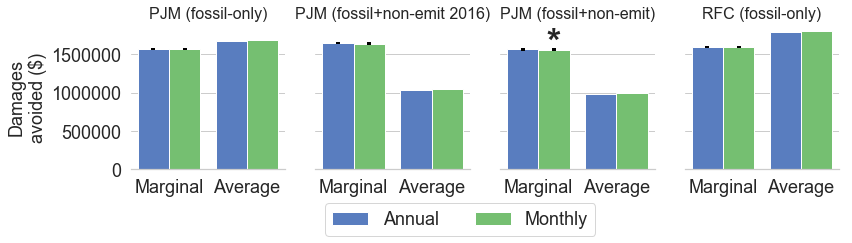

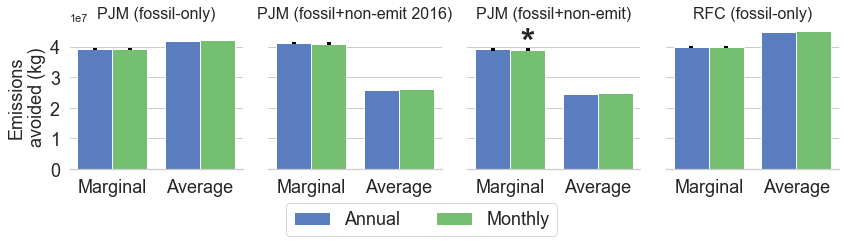

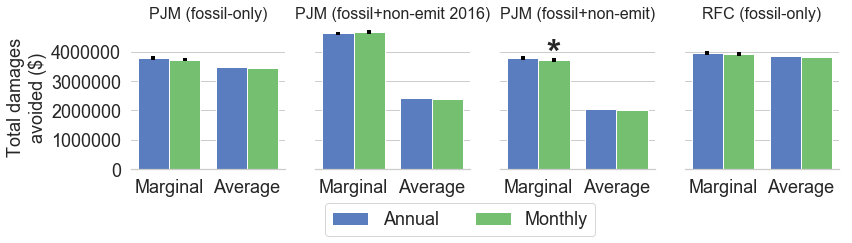

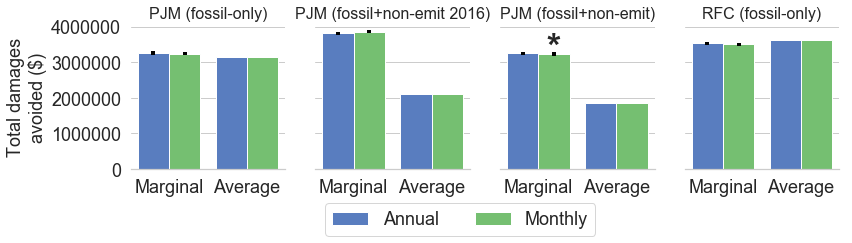

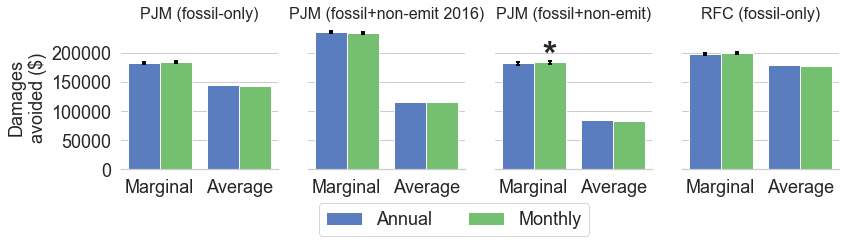

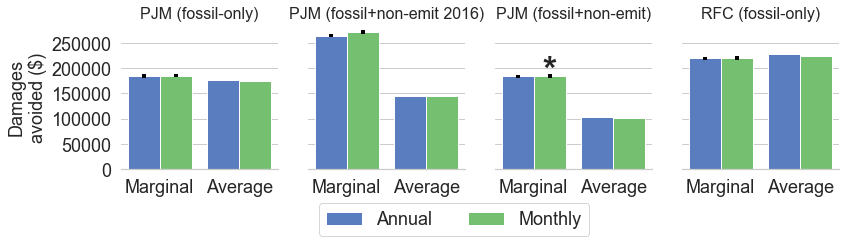

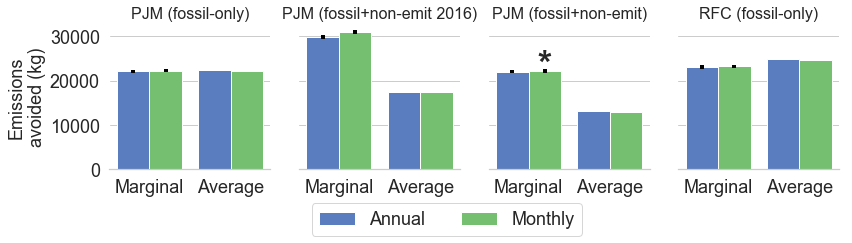

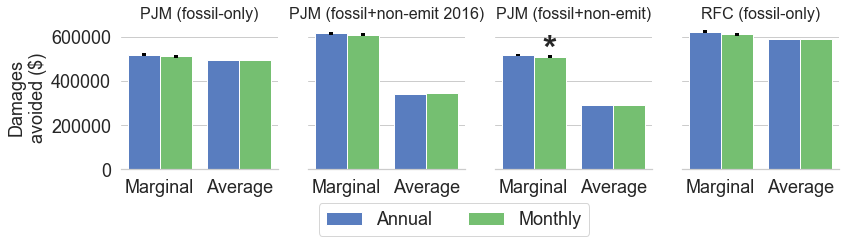

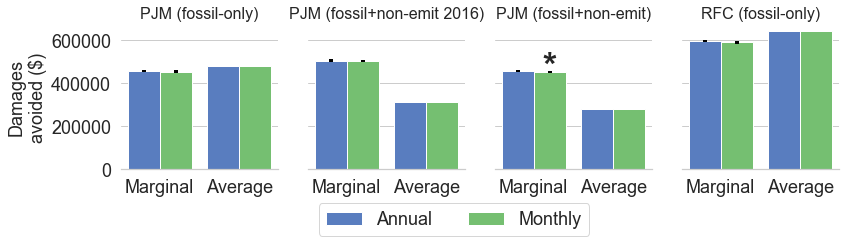

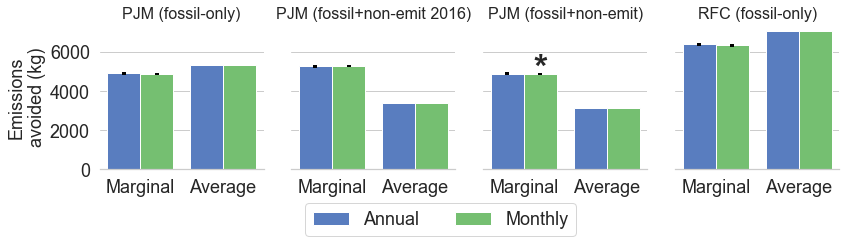

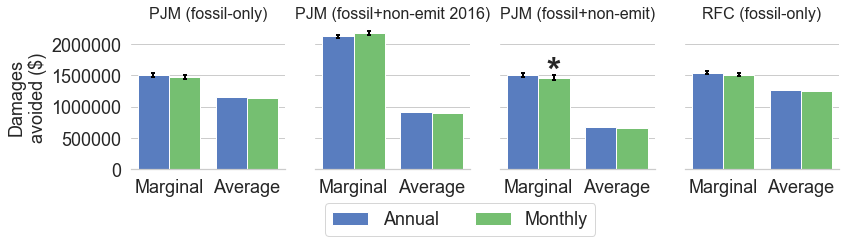

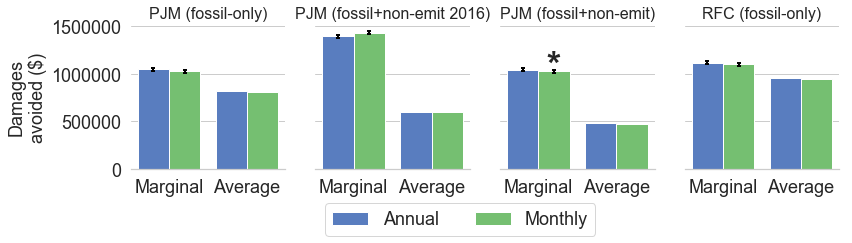

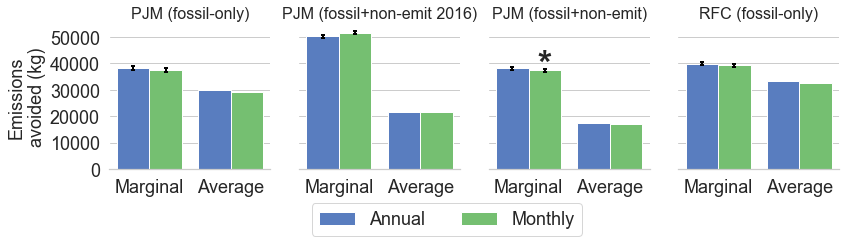

In [26]:
for label in LABELS:
    get_stacked_plot(label)

## Stacked bar plots for total damages 

In [27]:
import matplotlib.patches as mpatches

In [28]:
def plot_total_damages(dam_type, title=False):
    
    fontsize=18
    
    plt.rcParams['hatch.linewidth'] = 0.5
    sns.set(style="whitegrid", color_codes=True)

    dam_cols = dam_cols_eas if dam_type == 'EASIUR' else dam_cols_ap2
    se_col = 'dam_{}-se'.format('eas' if dam_type == 'EASIUR' else 'ap2')

    df = get_onelabel_formatted(dam_cols)  
    df = (df.set_index(['spat', 'kind', 'time'])/1e6).reset_index() # millions of dollars
    
    df_cum = df.set_index(['spat', 'kind', 'time']).cumsum(axis=1).reset_index()

    # Stacked bar plot
    g = sns.FacetGrid(data=df_cum, col='spat', size=3, aspect=1)
    hatches = ['||', '///', '', '\\\\\\']

    g.map(sns.barplot, 'kind', dam_cols[-1], 'time', 
          hue_order=['Annual', 'Monthly'], order=['Marginal', 'Average'],
          palette=sns.color_palette('muted')[::2], edgecolor='black', hatch=hatches[0])  
    g.map(sns.barplot, 'kind', dam_cols[-2], 'time', 
          hue_order=['Annual', 'Monthly'], order=['Marginal', 'Average'],
          palette=sns.color_palette('muted')[::2], edgecolor='black', hatch=hatches[1])
    g.map(sns.barplot, 'kind', dam_cols[-3], 'time', 
          hue_order=['Annual', 'Monthly'], order=['Marginal', 'Average'],
          palette=sns.color_palette('muted')[::2], edgecolor='black', hatch=hatches[2])
    g.map(sns.barplot, 'kind', dam_cols[-4], 'time', 
          hue_order=['Annual', 'Monthly'], order=['Marginal', 'Average'],
          palette=sns.color_palette('muted')[::2], edgecolor='black', hatch=hatches[3]).set_titles('{col_name}')
    g.despine(left='true')

    # Legend, fontsize, and other formatting
    xoffset=0.035

    for i, ax in enumerate(g.axes.flatten()):

        ax.set_xlabel('') # No x-label

        if i == 0:
            # y label on left plot
            ax.set_ylabel('Total damages\navoided (\$ millions)'.format(dam_type))

            # pollutants legend
            leg_dict = dict(zip(dam_cols, ['CO$_2$', 'SO$_2$', 'NO$_x$', 'PM$_{{2.5}}$']))
            dam_patches = []
            for dam, hatch in zip(dam_cols, hatches[::-1]):
                patch = mpatches.Patch(facecolor='white', label=leg_dict[dam], edgecolor='black', hatch=hatch)
                dam_patches.append(patch)

            lgd = ax.legend(handles=dam_patches, loc='center left', 
                            bbox_to_anchor=(0.3+xoffset, -0.15), ncol=4, frameon=True, fontsize=fontsize,
                            bbox_transform=plt.gcf().transFigure)
            plt.text(0.18+xoffset, -0.17, 'Pollutants:', transform=plt.gcf().transFigure,
                     fontsize=fontsize, fontweight='bold')
            lgd.get_frame().set_edgecolor('white')


        if i == 1:

            # temporal scope legend (same length as pollutants legend for alignment)
            blank_patch = mpatches.Patch(color='white', label='')
            ann_patch = mpatches.Patch(color=sns.color_palette('muted')[0], label='Annual', edgecolor='black')
            tod_patch = mpatches.Patch(color=sns.color_palette('muted')[2], label='Monthly', edgecolor='black')
            time_patches = [blank_patch, ann_patch, tod_patch, blank_patch]
            lgd2 = ax.legend(handles=time_patches, loc='center left', 
                            bbox_to_anchor=(0.3+xoffset, -0.0115), ncol=4, frameon=True, fontsize=fontsize,
                            bbox_transform=plt.gcf().transFigure)
            plt.text(0.11+xoffset, -0.0425, 'Temporal scopes:', transform=plt.gcf().transFigure, 
                     fontsize=fontsize, fontweight='bold')
            lgd2.get_frame().set_edgecolor('white')
            
        # Annotate baseline -- PJM fossil-plus marginal monthly
        if i == 2:
            baseline_x = 0.2
            patch_width = [p.get_width() for p in ax.patches][0]
            baseline_y = max([p.get_height() \
                          for p in ax.patches if abs(p.get_xy()[0]+patch_width/2-baseline_x)<=patch_width/4])
            ax.text(s='*', x=baseline_x, y=1.05 * baseline_y,
                   horizontalalignment='center', verticalalignment='center', 
                    fontsize=fontsize*2, fontweight='bold')

        # Set font size
        for item in ([#ax.title, 
                      ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
        ax.title.set_fontsize(fontsize-2)


    # Hacky errorbars
    #   TODO fix: divide by 1e6 to account for millions of dollars
    df_tot = get_onelabel_formatted(se_col[:-3])
    df_tot_se = get_onelabel_formatted(se_col)
    for i, ax in enumerate(g.axes[0]):
        spat = df_tot['spat'].dtype.categories[i]
        df_tot_slice = df_tot.query('spat == @spat').query('kind == "Marginal"')
        df_tot_se_slice = df_tot_se.query('spat == @spat').query('kind == "Marginal"')
        ax.errorbar([-0.2,0.2], df_tot_slice[se_col[:-3]].values/1e6,
                        yerr=df_tot_se_slice[se_col].values/1e6, ms=20, color='black', 
                        linewidth=0, elinewidth=2, capsize=2, capthick=2)   

    # Line around legend
    fig = plt.gcf()
    leg_line = \
        mpatches.Rectangle(
            (0.1+xoffset, -0.195), 0.77, 0.24, facecolor='none', edgecolor='lightgray', 
            transform=fig.transFigure, figure=fig)
    fig.patches.extend([leg_line])

    extra_artists = (lgd, lgd2)
    if title:
        sup=fig.text(0.5, 0.9, 'Total damages ({})\n'.format(dam_type), 
                         fontsize=fontsize, fontweight='bold', fontstyle='italic',
                        transform=fig.transFigure, ha='center')
        extra_artists = extra_artists + (sup,)

    plt.tight_layout()
    dirname = os.path.join('plots', 'demand_response')
    if not os.path.exists(dirname): os.makedirs(dirname)
    g.fig.savefig(os.path.join(dirname, 
                               '{}-stacked-with-error{}.pdf'.format(dam_type, '-titled' if title else '')),
                 bbox_extra_artists=extra_artists, bbox_inches='tight')

/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


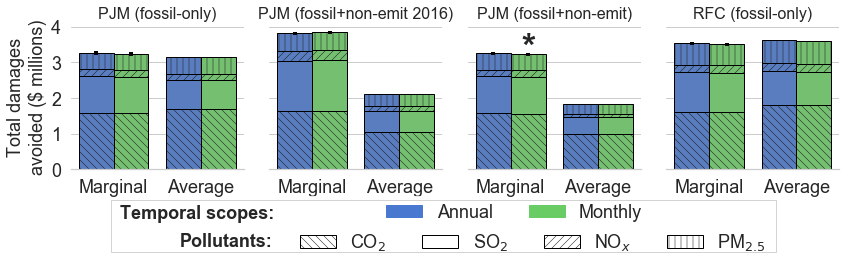

In [29]:
plot_total_damages('EASIUR', title=False)

/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


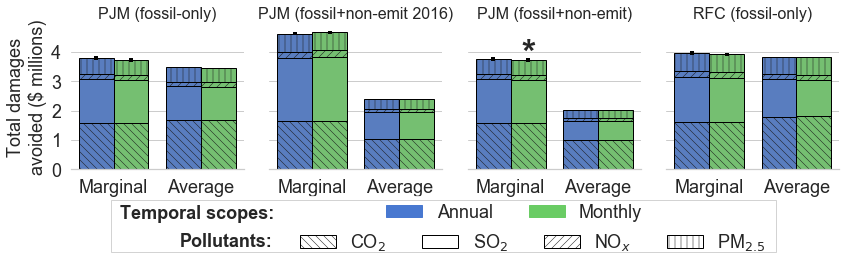

In [30]:
plot_total_damages('AP2', title=False)

## Sensitivity analysis 

What happens if DR reductions occur in highest marginal emissions hour of each month and get shifted to lowest marginal emissions hour of each month? Vice versa?

In [31]:
df_pjm_monthtod_fplus = get_factor_df(kind='MEF', time='MonthTOD', region='PJM', fuel_type='FossilPlus').loc[2017]
means = df_pjm_monthtod_fplus[LABELS]
stds = df_pjm_monthtod_fplus[['{}-se'.format(x) for x in LABELS]]

In [32]:
highest_factors = means.groupby(means.index.get_level_values('month'))[LABELS].max()
highest_factors_std = means.groupby(means.index.get_level_values('month'))[LABELS].idxmax().apply(
    lambda x: x.map(lambda y: stds.loc[y,'{}-se'.format(x.name)]))
highest_factors_std.columns = ['{}-se'.format(x) for x in highest_factors_std.columns]
highest_factors = pd.concat([highest_factors, highest_factors_std], axis=1)
highest_factors.index = intervention_df.index

In [33]:
lowest_factors = means.groupby(means.index.get_level_values('month'))[LABELS].min()
lowest_factors_std = means.groupby(means.index.get_level_values('month'))[LABELS].idxmin().apply(
    lambda x: x.map(lambda y: stds.loc[y,'{}-se'.format(x.name)]))
lowest_factors_std.columns = ['{}-se'.format(x) for x in lowest_factors_std.columns]
lowest_factors = pd.concat([lowest_factors, lowest_factors_std], axis=1)
lowest_factors.index = intervention_df.index

In [34]:
# Calculate effects
sensitivity_effects = {}
for key, df in zip(['highest', 'lowest'], [highest_factors, lowest_factors]):
    reds = df.multiply(intervention_df['MWh'], axis='index')
    effects = reds[LABELS].sum()  # total effect
    
    # Per-factor (non-independent) errors
    groupby_list = [reds.index.year, reds.index.month]
    per_factor_errors = reds[['{}-se'.format(x) for x in LABELS]].groupby(
        groupby_list).sum()
        
    # Combine per-factor errors to get independent errors
    ses = np.sqrt((per_factor_errors ** 2).sum())
#         ses = np.sqrt((reds[['{}-se'.format(x) for x in LABELS]] ** 2).sum())

    effects = pd.concat([effects, ses])
    sensitivity_effects[key] = effects

In [35]:
# Savings when do DR reductions when factors are highest and load shifted to when factors are lowest
savings = sensitivity_effects['highest'][LABELS] - sensitivity_effects['lowest'][LABELS]
savings_se = np.sqrt((sensitivity_effects['highest'][SE_LABELS])**2 + (sensitivity_effects['lowest'][SE_LABELS] ** 2))
savings_se.index = savings.index

In [36]:
results_df = pd.DataFrame((savings/1e6).round(2).astype(str) + ' $\pm$ ' + (savings_se/1e6).round(2).astype(str)).T
results_df

,co2_dam,co2_kg,dam_ap2,dam_eas,nox_dam_ap2,nox_dam_eas,nox_kg,pm25_dam_ap2,pm25_dam_eas,pm25_kg,so2_dam_ap2,so2_dam_eas,so2_kg
0,0.59 $\pm$ 0.06,14.64 $\pm$ 1.43,7.09 $\pm$ 1.14,4.4 $\pm$ 0.58,0.53 $\pm$ 0.08,0.34 $\pm$ 0.04,0.04 $\pm$ 0.0,0.32 $\pm$ 0.04,0.32 $\pm$ 0.03,0.0 $\pm$ 0.0,6.67 $\pm$ 1.14,3.9 $\pm$ 0.61,0.14 $\pm$ 0.02


In [37]:
emit_sens = results_df[[x for x in results_df.columns if 'dam' not in x]]
emit_sens

,co2_kg,nox_kg,pm25_kg,so2_kg
0,14.64 $\pm$ 1.43,0.04 $\pm$ 0.0,0.0 $\pm$ 0.0,0.14 $\pm$ 0.02


In [38]:
ap2_sens = results_df[[x for x in results_df.columns if 'ap2' in x or 'co2_dam' in x]]
ap2_sens

,co2_dam,dam_ap2,nox_dam_ap2,pm25_dam_ap2,so2_dam_ap2
0,0.59 $\pm$ 0.06,7.09 $\pm$ 1.14,0.53 $\pm$ 0.08,0.32 $\pm$ 0.04,6.67 $\pm$ 1.14


In [39]:
eas_sens = results_df[[x for x in results_df.columns if 'eas' in x or 'co2_dam' in x]]
eas_sens

,co2_dam,dam_eas,nox_dam_eas,pm25_dam_eas,so2_dam_eas
0,0.59 $\pm$ 0.06,4.4 $\pm$ 0.58,0.34 $\pm$ 0.04,0.32 $\pm$ 0.03,3.9 $\pm$ 0.61


In [40]:
colnames = ['\co', 'Total damage factor', '\\nox', '\partic', '\so']
ap2_sens.columns = colnames
eas_sens.columns = colnames
display_sens = pd.concat([ap2_sens, eas_sens])
display_sens = display_sens[['Total damage factor', '\co', '\so', '\\nox', '\partic']]
display_sens.index = ['AP2', 'EASIUR']
display_sens

,Total damage factor,\co,\so,\nox,\partic
AP2,7.09 $\pm$ 1.14,0.59 $\pm$ 0.06,6.67 $\pm$ 1.14,0.53 $\pm$ 0.08,0.32 $\pm$ 0.04
EASIUR,4.4 $\pm$ 0.58,0.59 $\pm$ 0.06,3.9 $\pm$ 0.61,0.34 $\pm$ 0.04,0.32 $\pm$ 0.03


In [41]:
print(display_sens.to_latex())

\begin{tabular}{llllll}
\toprule
{} & Total damage factor &              \textbackslash co &              \textbackslash so &             \textbackslash nox &          \textbackslash partic \\
\midrule
AP2    &     7.09 \$\textbackslash pm\$ 1.14 &  0.59 \$\textbackslash pm\$ 0.06 &  6.67 \$\textbackslash pm\$ 1.14 &  0.53 \$\textbackslash pm\$ 0.08 &  0.32 \$\textbackslash pm\$ 0.04 \\
EASIUR &      4.4 \$\textbackslash pm\$ 0.58 &  0.59 \$\textbackslash pm\$ 0.06 &   3.9 \$\textbackslash pm\$ 0.61 &  0.34 \$\textbackslash pm\$ 0.04 &  0.32 \$\textbackslash pm\$ 0.03 \\
\bottomrule
\end{tabular}

